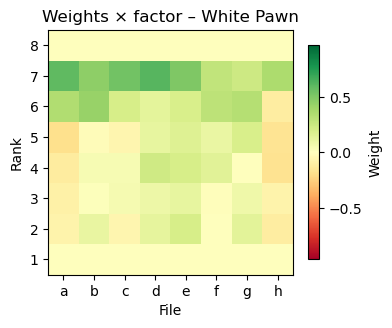

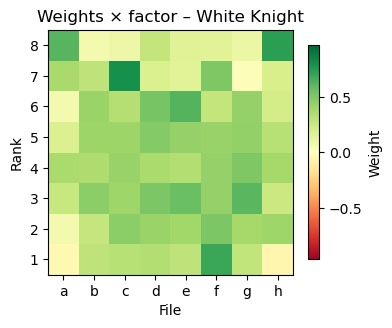

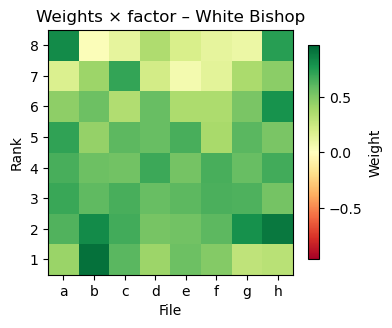

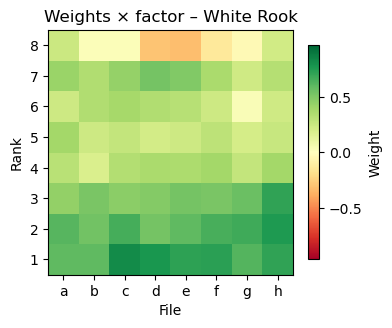

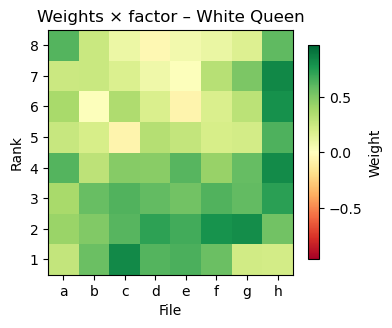

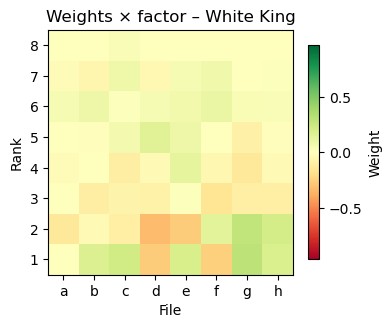

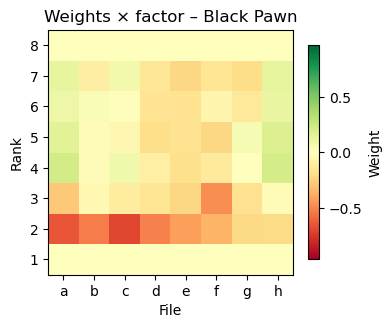

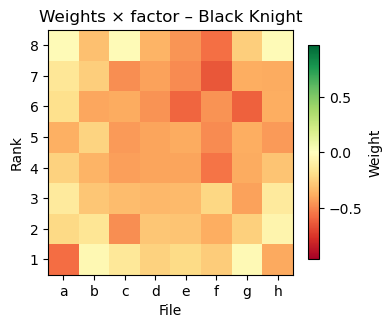

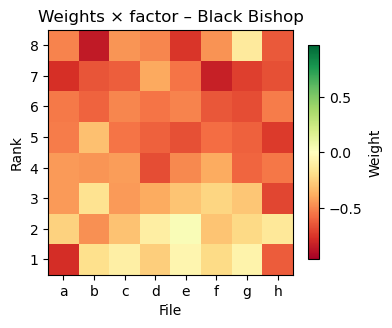

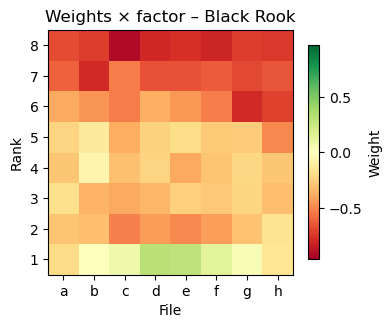

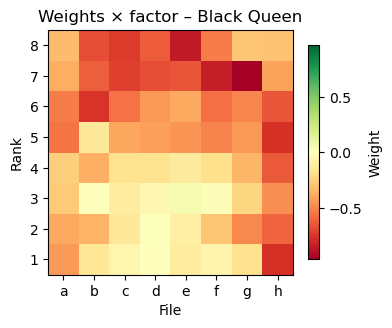

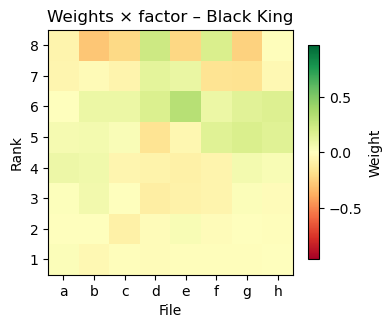

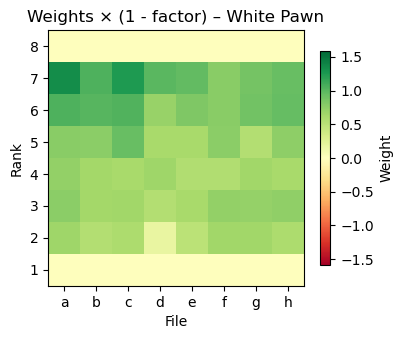

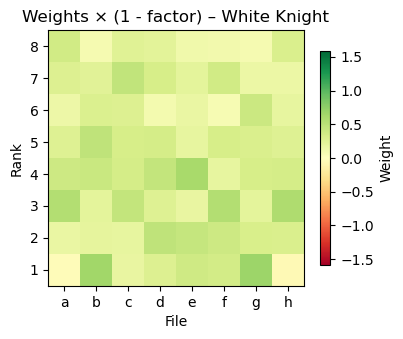

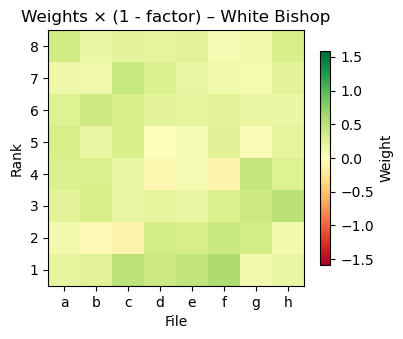

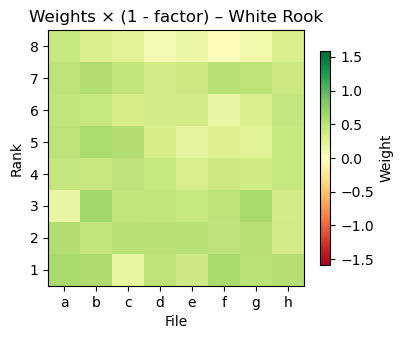

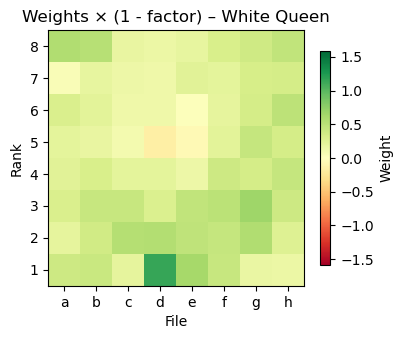

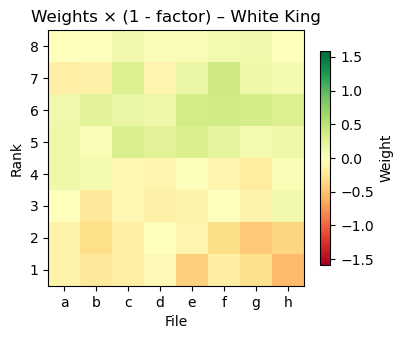

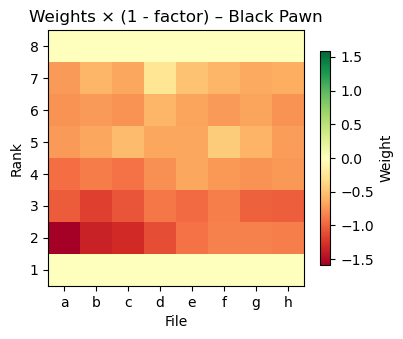

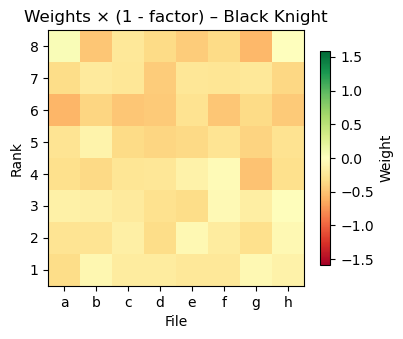

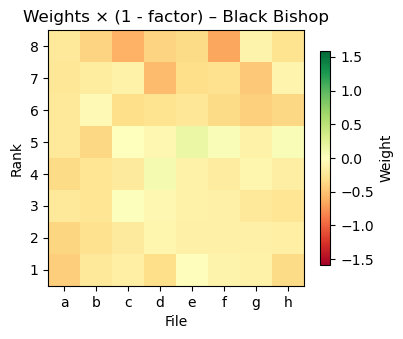

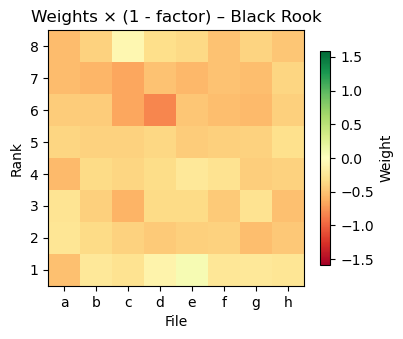

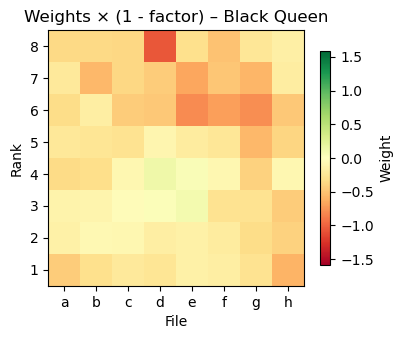

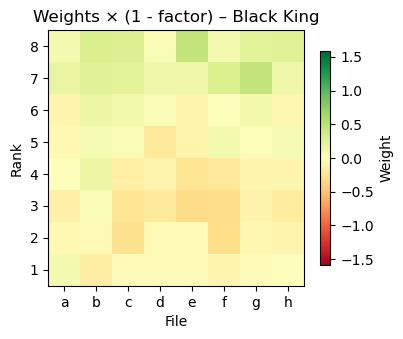

In [2]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from sklearn.linear_model import LogisticRegression

# ─── 1. Load your trained LogisticRegression ───────────────────────────────────
model: LogisticRegression = joblib.load('chess_lr.joblib')

# Here coef_[2] - coef_[0] yields a single (1544,) vector; adjust if your index usage differs.
coef_flat = model.coef_[2] - model.coef_[0]   # shape == (1544,) if n_features == 2 * 772

additional_features = 8
half_feature_count = 12 * 64 + additional_features

# ─── 2. Sanity‐check dimensions ─────────────────────────────────────────────────
n_total = coef_flat.shape[0]
if n_total != half_feature_count*2:
    raise ValueError(f"Expected {half_feature_count*2} weights, but found {n_total}")

# ─── 3. Split into the two “half” blocks of length 772 ───────────────────────────
w_factor    = coef_flat[:half_feature_count]        # weights corresponding to features * factor
w_invfactor = coef_flat[half_feature_count:half_feature_count*2] # weights corresponding to features * (1 - factor)

# ─── 4. Separate out the piece‐square weights (first 768 entries of each) ───────
# Reshape each half into (12, 8, 8) directly, so we can plot them separately.
boards_factor    = w_factor[:768].reshape(12, 64).reshape(12, 8, 8)
boards_invfactor = w_invfactor[:768].reshape(12, 64).reshape(12, 8, 8)

# ─── 5. Extract castling‐rights weights from each half (next 4 entries) ────────
additional_factor    = w_factor[768:half_feature_count]
additional_invfactor = w_invfactor[768:half_feature_count]

# ─── 6. Plotting utility ─────────────────────────────────────────────────────────
piece_names = [
    'White Pawn', 'White Knight', 'White Bishop', 'White Rook',
    'White Queen', 'White King',
    'Black Pawn', 'Black Knight', 'Black Bishop', 'Black Rook',
    'Black Queen', 'Black King'
]
files = list('abcdefgh')
ranks = list('12345678')

def plot_boards(boards, title_prefix):
    """
    Plot a list of 12 (8×8) boards using a diverging colormap.
    `boards` should be a NumPy array of shape (12, 8, 8).
    `title_prefix` is a string to prepend to each subplot’s title.
    """
    max_abs = np.max(np.abs(boards))
    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0.0, vmax=max_abs)

    for idx, name in enumerate(piece_names):
        board = boards[idx]

        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(board, cmap='RdYlGn', norm=norm, origin='lower')
        ax.set_xticks(range(8))
        ax.set_xticklabels(files)
        ax.set_yticks(range(8))
        ax.set_yticklabels(ranks)
        ax.set_xlabel('File')
        ax.set_ylabel('Rank')
        ax.set_title(f"{title_prefix} – {name}")
        fig.colorbar(im, ax=ax, shrink=0.6, orientation='vertical', label='Weight')
        plt.tight_layout()
        plt.show()


# ─── 7. Plot “factor” half ───────────────────────────────────────────────────────
plot_boards(boards_factor, title_prefix="Weights × factor")

# ─── 8. Plot “invfactor” half ───────────────────────────────────────────────────
plot_boards(boards_invfactor, title_prefix="Weights × (1 - factor)")

In [3]:
additional_factor

array([ 0.0068686 , -0.00487175, -0.02797331,  0.02647243,  0.06792456,
       -0.06664923,  2.75555009, -2.87586976])

In [4]:
additional_invfactor

array([ 0.09666115, -0.10044822,  0.26098438, -0.26702654,  0.0042793 ,
       -0.00759531,  1.53884312, -1.29788107])